# Linear conjugate gradient

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Seaborn
PyPlot.svg(true)

true

In this noteboook we implement and investigate the linear conjugate gradient algorithm on a few toy examples.

In [2]:
function iterate_CG(xk, rk, pk, A)
    """
    Basic iteration of the conjugate gradient algorithm
    Parameters:
    xk: current iterate
    rk: current residual
    pk: current direction
    A: matrix of interest
    """
    
    # form products
    rkk = rk' * rk
    Apk = A * pk 
    
    # construct step size
    αk = rkk / (pk' * Apk)

    # take a step in current conjugate direction
    xk_new = xk + αk * pk

    # construct new residual
    rk_new = rk + αk * Apk

    # construct new linear combination
    betak_new = (rk_new' * rk_new) / rkk

    # generate new conjugate vector
    pk_new = -rk_new + betak_new * pk

    return xk_new, rk_new, pk_new

end

iterate_CG (generic function with 1 method)

In [3]:
function run_conjugate_gradient(x0, A, b; max_iter = 2000)
    """
    Conjugate gradient algorithm

    Parameters:
    x0: initial point
    A: matrix of interest
    b: vector in linear system (Ax = b)
    max_iter: max number of iterations to run CG
    """

    # initial iteration
    xk = x0
    rk = A * xk - b
    pk = -rk
    
    err = sum(abs.(rk))
    errors = [err]
    D = pk

    #while sum(abs.(rk)) > 10e-6
    for i in 1:max_iter
        xk, rk, pk = iterate_CG(xk, rk, pk, A)
        
        D = hcat(D,pk)
        
        err = sum(abs.(rk))
        push!(errors, err)
        
        # print iteration
        i % 500 == 0 && println("Iteration $i: error: $err")

        # break if we reach desired error 
        if err < 10e-6
            println("Terminated in $i iterations")
            break
        end
    end
    
    return xk, errors, D
end

run_conjugate_gradient (generic function with 1 method)

## Simple diagonal example

Here we look at a diagonal matrix with 3 eigenvalues that are around 10, thus with about 3 "effective" eigenvalues. We see that the error drops sharply at 4 iterations, and then again in the 5th iteration. The algorithm terminates in 5 iterations.

In [4]:
Random.seed!(123)
b = rand(5)

5-element Array{Float64,1}:
 0.7684476751965699
 0.940515000715187 
 0.6739586945680673
 0.3954531123351086
 0.3132439558075186

In [5]:
A = zeros(5,5)
A[1,1]=10; A[2,2]=10.1; A[3,3]=10.2; A[4,4]=2; A[5,5] = 1

1

In [6]:
x = A \ b

5-element Array{Float64,1}:
 0.07684476751965699
 0.09312029710051357
 0.06607438182039876
 0.1977265561675543 
 0.3132439558075186 

In [7]:
x0 = [0.3,0.1,0.1,0.1,0.1]
xsol, errors, D = run_conjugate_gradient(x0, A, b);
xsol

Terminated in 5 iterations


5-element Array{Float64,1}:
 0.076844767519657  
 0.09312029710051356
 0.06607438182039876
 0.19772655616755433
 0.3132439558075186 

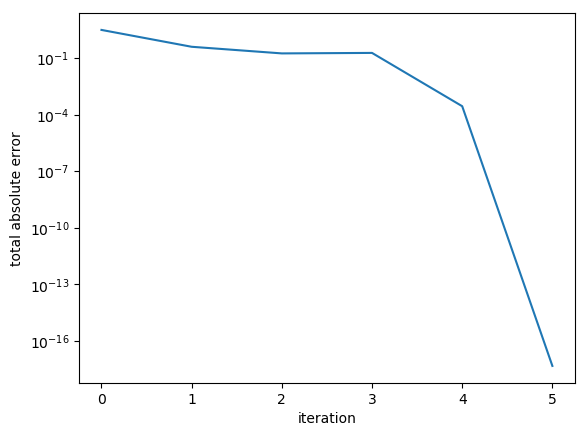

In [8]:
Seaborn.semilogy(0:length(errors)-1, errors)
xlabel("iteration"); ylabel("total absolute error")
#savefig("/Users/dicai/git/blog/assets/ex1.png")

### Quick check for conjugacy

We'll quickly check a few of the directions to see that they are indeed conjugate.

In [9]:
# confirm these are 0
@assert D[:,1]' * A * D[:,2] < 10e-6
@assert D[:,1]' * A * D[:,3] < 10e-6
@assert D[:,1]' * A * D[:,4] < 10e-6

# confirm these aren't 0
@assert D[:,1]' * A * D[:,1] < 10e-6

AssertionError: AssertionError: (D[:, 1])' * A * D[:, 1] < 1.0e-5

## Random matrix example

Here we generate a random s.p.d. matrix. Here we see a sharp decrease in error at 5 iterations and otherwise slight decreases in error at the earlier iterations.

In [10]:
# Construct a random symmetric positive definite matrix
Random.seed!(111)
A = rand(5,5); A = 0.5*(A+A'); A = A + 5*I;

In [11]:
eigvals(A) 

5-element Array{Float64,1}:
 4.46066817714894  
 4.979395596044116 
 5.2165679905921785
 5.56276039133931  
 7.909981699390226 

In [12]:
x2 = A \ b

5-element Array{Float64,1}:
 0.11716900362730469
 0.1405752373046519 
 0.08834694285802892
 0.03420963755766211
 0.0129462608414192 

In [13]:
x0 = [0.,0.,0.,0.,0.]
xsol, errors, D = run_conjugate_gradient(x0, A, b);
xsol

Terminated in 5 iterations


5-element Array{Float64,1}:
 0.1171690036273047  
 0.14057523730465188 
 0.08834694285802895 
 0.03420963755766211 
 0.012946260841419187

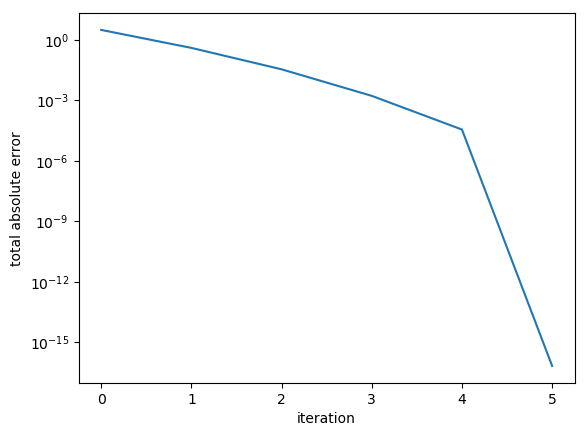

In [14]:
Seaborn.semilogy(0:length(errors)-1, errors)
xlabel("iteration"); ylabel("total absolute error")

## Larger example

We'll look at a larger example now, again generating a random s.p.d. matrix. Here the matrix ndim = 1000. We examine the following matrices:
1. Larger diagonal
2. Smaller diagonal

We print the condition number of each matrix, and we can see that the second problem is much more ill-conditioned, which essentially results in more numerical errors (and thus, more iterations). 

Running the code with increased dimension will generally require more iterations.

### Larger diagonal

In [15]:
N = 1000
Random.seed!(123)
b = rand(N)
A = rand(N,N); A = 0.5*(A+A'); A = A + 50*I;
println("The condition number is: ", cond(A))

The condition number is: 14.832223763483976


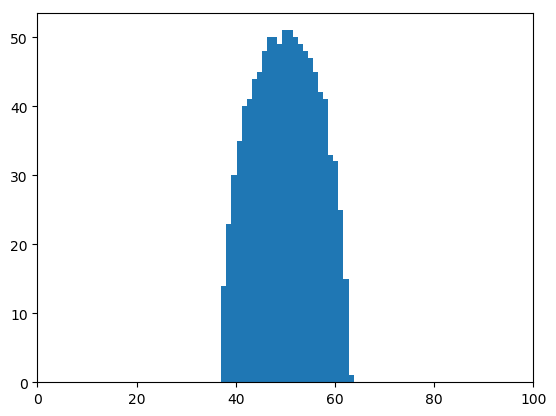

In [16]:
# distribution of the eigenvalues
plt[:hist](eigvals(A), bins=500); xlim(0,100)

In [17]:
x0 = zeros(N)
xsol, errors, D = run_conjugate_gradient(x0, A, b);
xsol;

Terminated in 11 iterations


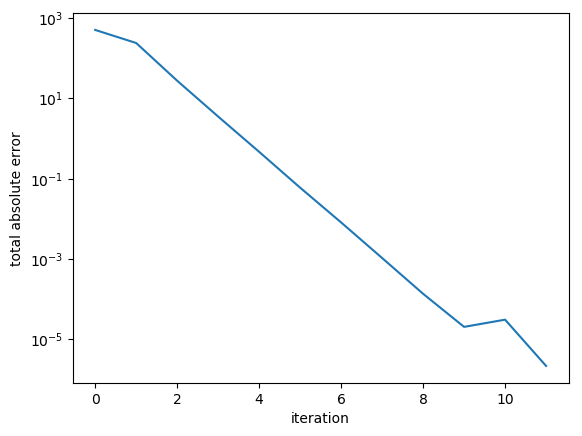

In [18]:
Seaborn.semilogy(0:length(errors)-1, errors)
xlabel("iteration"); ylabel("total absolute error")

### Examine conjugacy property

In [19]:
D[:,1]' * A * D[:,2]

-3.703348738781642e-11

In [20]:
D[:,1]' * A * D[:,10]

-0.003039049255638625

In [21]:
D[:,1]' * A * D[:,33]

BoundsError: BoundsError: attempt to access 1000×12 Array{Float64,2} at index [Base.Slice(Base.OneTo(1000)), 33]

### Smaller diagonal

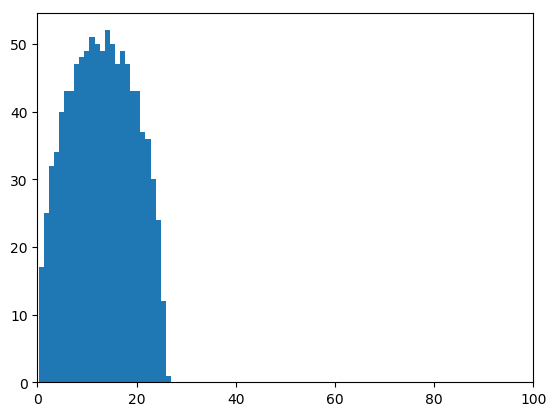

The condition number is: 2054.8953570922145


In [22]:
Random.seed!(123)

# Generate random s.p.d. matrix
A = rand(N,N); A = 0.5*(A+A'); A = A + 13*I;
println("The condition number is: ", cond(A))

# distribution of the eigenvalues
plt[:hist](eigvals(A), bins=500); xlim(0,100)

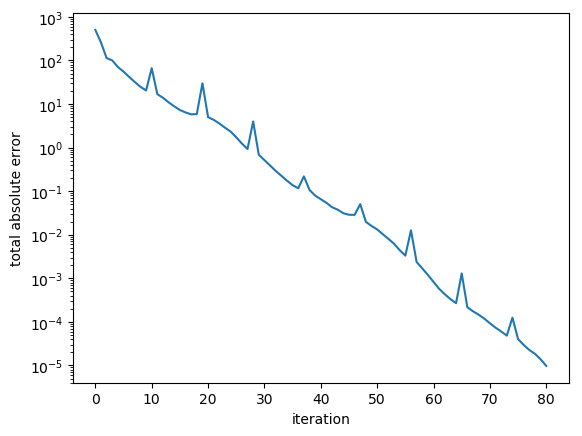

Terminated in 80 iterations


In [23]:
x0 = zeros(N)
xsol, errors, D = run_conjugate_gradient(x0, A, b; max_iter=5000);

Seaborn.semilogy(0:length(errors)-1, errors)
xlabel("iteration"); ylabel("total absolute error")

### Examine the conjugacy property

In [24]:
D[:,1]' * A * D[:,2]

2.3504753698944114e-11

In [25]:
D[:,1]' * A * D[:,7]

-0.008916006321349812

In [26]:
D[:,1]' * A * D[:,75]

0.029404348791532815